<a href="https://colab.research.google.com/github/mehuldas13/Xaviers-Analytics/blob/master/NLP_End_Sem_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP : Spam detection in SMS (text) data using TensorFlow2**

---
**Introduction**
Today, internet and social media have become fastest and easiest ways to get information. In this age, reviwes, opinions, feedbacks, messages and recommendations have become significant source of informtion. Thanks to advancement in technologies, we are now able to extract meaningful information out of such data using various Natural Language Processing (NLP) techniques. NLP , a branch of Artificial Intelligence (AI) makes use of computers and human natural language to output valuable information. NLP is commonly used in text classification task such as spam detecetion and sentiment analyisis, text generation, language translations and document classification.

---
**Purpose**
The main purpose of this article is to understand how we can use TensorFlow2 to build spam detection model. Particulary, we focus on building a binary classification model to detect which text messages are spam or not (aka Ham). Moroever, given a text message we’ve never seen before, detect whether or not that message is Spam or Ham.

---
**Data**
This a text data downloaded from UCI datasets. It contains 5169 SMS phone messages. The data were collected for the purpose of mobile phone spam research. The data have been labled as either spam or ham.

---
**Method**
We will use Dense text classifier , Long Short Term Memory(LSTM) and Bi-directional LSTM and compare these methods in terms of performance and runtime.

The work here is broken down in multiple steps:

1.Load and explore the spam data

2.Prepare train test data  

3.Train the spam detection model using the three approaches metioned earlier

4.Select one as a final model

5.Use the final trained classifier to classify the text


In [1]:
 import tensorflow as tf

In [90]:
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional

In [3]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam (2).csv


In [8]:
messages = pd.read_csv("spam (2).csv",encoding='latin-1')
messages.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
messages.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


The summary statistics and visualize the data. The describe() method from pandas provide a summary statistics. Such as, there are 5,572 labels and messages. There are two unique labels indicating for “ham” and “spam”. We can also observe that there are less unique messages (5,169) than total message count(5,572) indicating some repeated messages. The top label is “ham” and the top message in the data is “Sorry, I’ll call later”. The duplicatedRow below shows, there are 403 duplicated messages.

---
There are 4,825 ham compared to 747 spam messages. This indicates the imbalanced data which we will fix later. The most popular ham message is “Sorry, I’ll call later”, whereas the most popular spam message is “Please call our customer service…” which occurred 30 and 4 times, respectively.



In [10]:
messages.groupby("label").describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [11]:
messages['length']=messages['text'].apply(len)
messages.head()

,label,text,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Visualize the percentage of Spam vs. Ham on piechart:

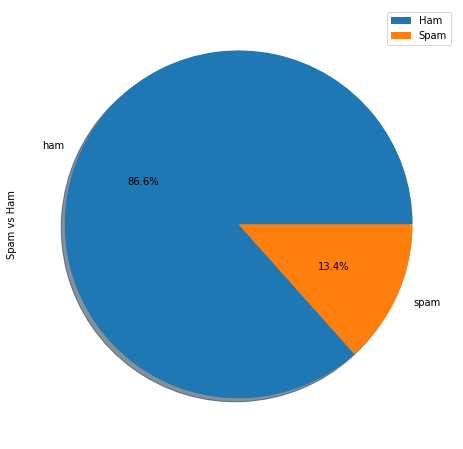

In [12]:
messages["label"].value_counts().plot(kind = 'pie', figsize = (8, 8), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

A lot of messages are actually not spam. About 86% of our dataset consists of normal messages.

A very basic model would be a model that predicts everything as ham. It would have a decent accuracy. But then again, is that right? No. We will then have to use an accuracy metric that keeps this in mind. Goal : We don't mind if we miss the odd spam message but we surely don't want to mark a ham message as spam i.e Precision is very important. Hence we will use fbeta score as our accuracy metric with inclination towards Precision.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d2f7b8518>,
      dtype=object)

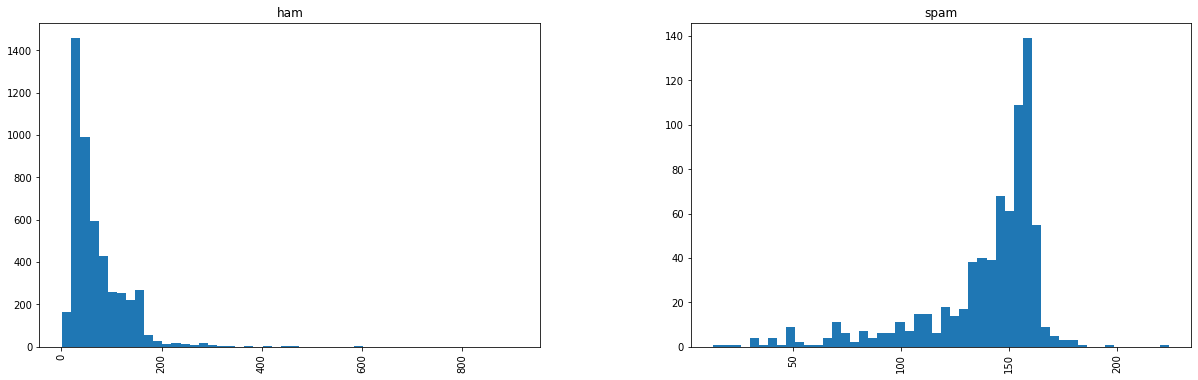

In [14]:
messages.hist(column='length',by='label',bins=50, figsize=(20,6))

Explored the data by label groups by creating a WordCloud and a bar chart. Created a separate dataframe for ham and spam message and convert it to numpy array to generate WordCloud.

In [27]:
# get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# For ham and spam messages, create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.text.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.text.to_numpy().tolist())

To visualize using WordCloud(), we extract words most commonly found in ham and spam messages, remove meaningless stop words such as “the”, “a” , “is” etc, and plot it. The WordCloud visualizes the most frequent words in the given text.

In [28]:
ham_msg_text[:300]

"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... Ham top WordsOk lar... Joking wif u oni... Ham top WordsU dun say so early hor... U c already then say... Ham top WordsNah I don't think he goes to usf, he lives around here though Ham top"

The ham message WordCloud below shows that “now”, “work”, “Time”, “Ok” and “Sorry” are the most commonly appeared word in ham messages.

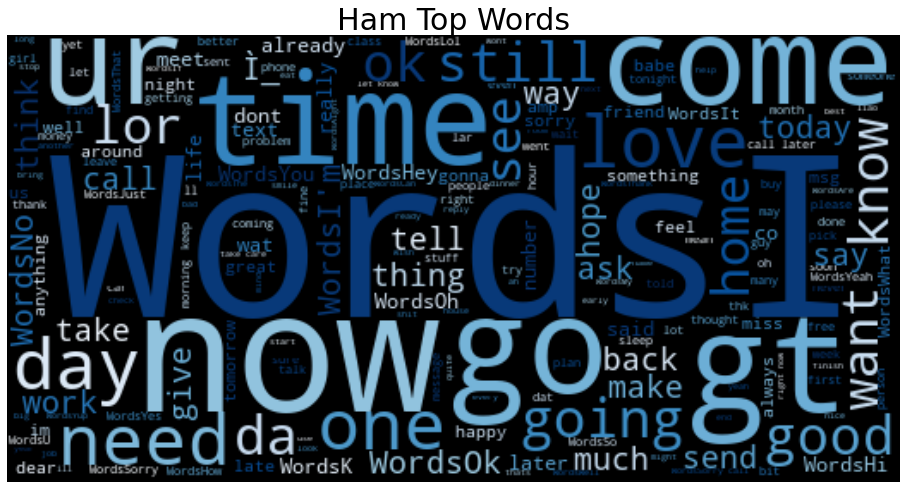

In [48]:

# wordcloud of ham messages
customStopwords=list(STOPWORDS)+['Ham','top','this','Words','lt','got','will']
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=customStopwords, 
                          background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.title("Ham Top Words",fontsize=30)
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

The spam message WordCloud below shows that “Free”, “call”, “text”, “claim” and“reply” are most commonly appeared words in spam messages.

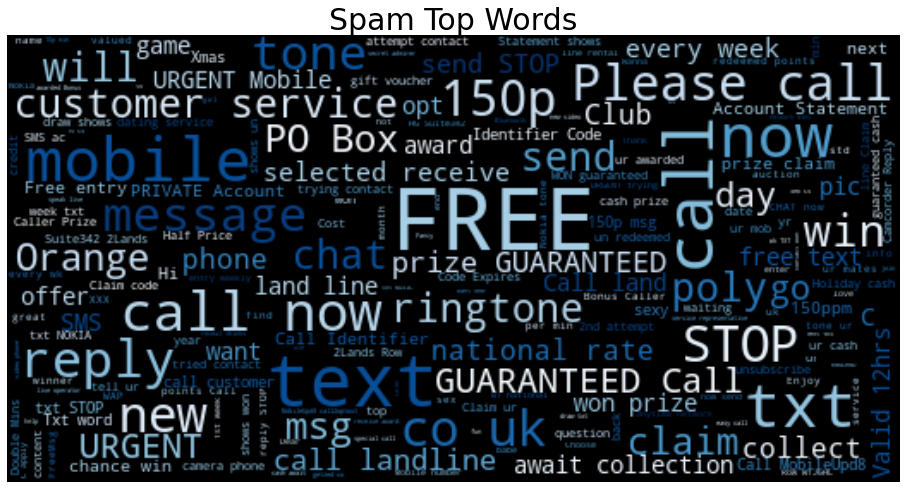

In [49]:

# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, 
                          background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.title("Spam Top Words",fontsize=30)
plt.axis('off') # turn off axis
plt.show()

Below, the bar chart shows that the classes are imbalanced. There are most frequent ham messages (85%) than spam (15%).

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.481865284974095

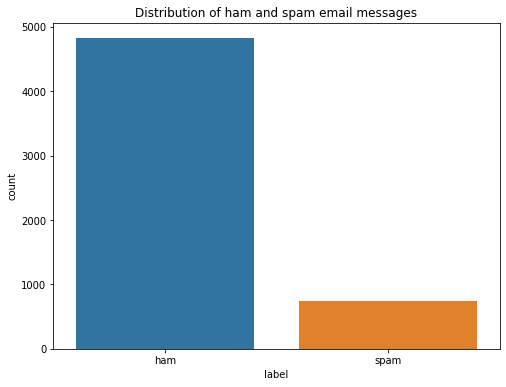

In [51]:
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
plt.title('Distribution of ham and spam email messages')

In [52]:
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100

15.481865284974095

Downsampling is a process where you randomly delete some of the observations from the majority class so that the numbers in majority and minority classes are matched. Below, we have downsampled the ham messages (majority class). There are now 747 messages in each class.

In [53]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg

In [54]:
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 3) (747, 3)


In [55]:
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

Below chart shows a similar distribution across message types after accounting for the imbalanced data.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

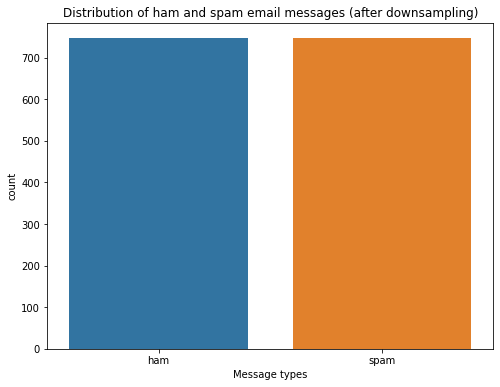

In [56]:
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

Furthermore, on average, the ham message has length of 73 words whereas spam message has 138. The length information may be useful when we set maxlen parameter later.

In [58]:

# Get length column for each text
msg_df['text_length'] = msg_df['text'].apply(len)

#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,length,text_length
label,,
ham,69.626506,69.626506
spam,138.866131,138.866131


Prepare train/test data and pre-process text.
After exploring and accounting for imbalanced data, next let’s convert the text label to numeric and split the data into training set and testing set. Also, convert label to numpy arrays to fit deep learning models. 80% of data were used for training and 20% for testing purposes.

In [59]:
#msg_df['msg_type']= msg_df['label'].apply(lambda x: 1 if x =='spam' else 0)
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [61]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['text'], msg_label, test_size=0.2, random_state=434)


**Tokenization**
As deep learning models do not understand text, let’s convert text into numerical representation. For this purpose, a first step is Tokenization. The Tokenizer API from TensorFlow Keras splits sentences into words and encodes these into integers. Tokenizer() does all the required pre-processing such as
tokenize into word or character — here we use at word level
num_words for maximum number of unique tokens hence we can filter out rare words
filter out punctuation terms
convert all words to lower case
convert all words to integer index
First, define hyper-parameters used for pre-processing. We’ll describe these hyper-parameters later.

In [62]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # pad_sequences parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

In [63]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

**Hyper-parameters** used in Tokenizer object are: num_words and oov_token, char_level.
num_words: Indicate how many unique words to load in training and testing data. For our purpose, we selected 500 words (vocab_size)
oov_token: When its used, out of vocabulary token will be added to word index in the corpus which is used to build the model. This is used to replace out of vocabulary words (words that are not in our corpus) during text_to_sequence calls (see below).
char_level: If it is “True” then every character will be treated as a token. We set it as “False”, hence every word will be treated as a token.
We can get the word_index using tokenizer.word_index. A snapshot of word_index is printed below.

In [64]:
# Get the word_index
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'now': 11,
 'is': 12,
 '2': 13,
 'and': 14,
 'free': 15,
 'in': 16,
 'or': 17,
 'have': 18,
 'on': 19,
 'ur': 20,
 'of': 21,
 'txt': 22,
 'with': 23,
 'are': 24,
 '4': 25,
 'from': 26,
 'me': 27,
 'text': 28,
 'get': 29,
 'stop': 30,
 'mobile': 31,
 'my': 32,
 'this': 33,
 'be': 34,
 'just': 35,
 'claim': 36,
 'only': 37,
 'it': 38,
 'reply': 39,
 'that': 40,
 'www': 41,
 'no': 42,
 'out': 43,
 'will': 44,
 'at': 45,
 'we': 46,
 'do': 47,
 'so': 48,
 'send': 49,
 'our': 50,
 'not': 51,
 'prize': 52,
 'new': 53,
 'if': 54,
 'cash': 55,
 'but': 56,
 'go': 57,
 'can': 58,
 '150p': 59,
 'up': 60,
 'uk': 61,
 "i'm": 62,
 'please': 63,
 'nokia': 64,
 'who': 65,
 'win': 66,
 't': 67,
 'won': 68,
 '1': 69,
 'all': 70,
 'tone': 71,
 'what': 72,
 'week': 73,
 'com': 74,
 'been': 75,
 'msg': 76,
 'want': 77,
 'phone': 78,
 'know': 79,
 '50': 80,
 'service': 81,
 'by': 82,
 'urgent': 83,
 '

In [65]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4054 unique tokens in training data. 


**Sequencing and Padding**

After tokenization, we represent each sentence by sequences of numbers using texts_to_sequences() from tokenizer object. Subsequently, we use pad_sequences() so that each sequence will have same length. Sequencing and padding are done for both training and testing data.

In [66]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

padding = ‘pre’ or ‘post (default pre). By using pre, we pad before each sequence and by using post we pad after each sequence.

maxlen = maximum length of all sequences. Here max_len=50 hence, we are only going to use 50 words in a sentence. If not provided, by default it will use the maximum length of the longest sentence.

truncating = ‘pre’ or ‘post’ (default ‘pre’). If a sequence length is larger than the provided maxlen value then, these values will be truncated to maxlen. ‘pre’ option will truncate at the beginning where as ‘post’ will truncate at the end of the sequences.

In [67]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


Before padding, first sequence is 27 word long where as second one is 24. Once the padding was applied, both sequences have length of 50.

In [68]:
# Before padding : first sequence is 27 character long where as second one is 24
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [69]:
# Padded to same length of 50
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [70]:
# As can be seen from below, the padded sequence is 50 words long. 
print(training_padded[0])

[  1  37 200   8  31   1   3  24   1   2 241   2   7 148 264 127  31  10
  15   6   7  31 241  87  15  19   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


**Dense Spam Detection Model**

With our data loaded and preprocessed, we’re now well prepared to use neural network architecture to classify the text message. Let’s train the model using a Dense architecture followed by LSTM and Bi-LSTM.
Define hyper-parameters:

In [71]:
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

Below is a model architecture of dense spam detection model.

In [72]:
#Dense sentiment model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

The model.summary() below, provides the layer, shape and number of parameters used in each layer. In the embedding layer, the 8000 parameter comes from 500 words (vocab_size), each one with a 16 dimensional word-vector space (500 X 16 =8000). The embedding layer is passed through GlobalAveragePooling1D and into dense layers have shape of 16 (due to the average pooling along 16 embedding dimension). We selected 24 neurons for the dense hidden layer. Each of the 24 neurons in the dense layer gets input from each of the 16 values coming from the GlobalAveragePooling1D layer, for a total of 384 (16 X 24) weights and 24 biases (one for each 24 neurons). Hence the total parameter is 408. Finally, the output layer has 24 weights (one for each neuron) and its one bias term resulting 25 parameters in total.

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


Compiling the Dense model

We use ‘binary_crossentropy’ as a loss function because of binary output, ‘adam’ as an optimiser which makes use of momentum to avoid local minima and ‘accuracy’ as a measure of model performance.

In [74]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

**Training and evaluating the Dense model**

Next, let’s fit our dense classifier using model.fit() argument. It uses padded training data and training labels for training the model and validation data for validating.

**epoch:** Number of times the learning algorithm will work through the entire training data set. We set it to be 20.
callbacks: callbacks is used to pass the early stopping parameter. EarlyStopping(monitor=’val_loss’, patience=2) is used to define that we want to monitor the validation loss and if the validation loss is not improved after two epochs, then the model training is stopped. It helps to avoid overfitting problem and indicates when to stop training before the learner begins over-fit. As depicted in the history results below, the validation loss is increased (i.e. not improved), continuously for 2 epochs (epoch 24: 0.12, and epoch 25: 0.13) after epoch 23, hence the model fitting has stopped at epoch 26.
**verbose** =2: lets to print loss and accuracy on each epoch

In [75]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 0s - loss: 0.6849 - accuracy: 0.7121 - val_loss: 0.6729 - val_accuracy: 0.7826
Epoch 2/30
38/38 - 0s - loss: 0.6528 - accuracy: 0.8410 - val_loss: 0.6302 - val_accuracy: 0.8395
Epoch 3/30
38/38 - 0s - loss: 0.5912 - accuracy: 0.8711 - val_loss: 0.5568 - val_accuracy: 0.8595
Epoch 4/30
38/38 - 0s - loss: 0.5063 - accuracy: 0.8803 - val_loss: 0.4696 - val_accuracy: 0.8729
Epoch 5/30
38/38 - 0s - loss: 0.4155 - accuracy: 0.8937 - val_loss: 0.3909 - val_accuracy: 0.8796
Epoch 6/30
38/38 - 0s - loss: 0.3399 - accuracy: 0.8971 - val_loss: 0.3243 - val_accuracy: 0.8997
Epoch 7/30
38/38 - 0s - loss: 0.2777 - accuracy: 0.9205 - val_loss: 0.2726 - val_accuracy: 0.9064
Epoch 8/30
38/38 - 0s - loss: 0.2331 - accuracy: 0.9305 - val_loss: 0.2287 - val_accuracy: 0.9130
Epoch 9/30
38/38 - 0s - loss: 0.2007 - accuracy: 0.9406 - val_loss: 0.1954 - val_accuracy: 0.9298
Epoch 10/30
38/38 - 0s - loss: 0.1749 - accuracy: 0.9473 - val_loss: 0.1692 - val_accuracy: 0.9365
Epoch 11/30
38/38 -

The model resulted , training loss: 0.07, training accuracy: 97%, validation loss: 0.13 and validation accuracy: 94%.

In [76]:
# Model performance on test data is about 94.65% accuracy with validation loss of 0.11.
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 1ms/step - loss: 0.0840 - accuracy: 0.9699


[0.08397810161113739, 0.9698996543884277]

We can further visualize the history results by plotting loss and accuracy by number of epochs.

In [77]:
metrics = pd.DataFrame(history.history)
metrics[:2]

,loss,accuracy,val_loss,val_accuracy
0,0.684907,0.712134,0.672892,0.782609
1,0.652849,0.841004,0.630164,0.839465


In [78]:
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]

,Training_Loss,Training_Accuracy,Validation_Loss,Validation_Accuracy
0,0.684907,0.712134,0.672892,0.782609
1,0.652849,0.841004,0.630164,0.839465


Figure below shows, loss over number of epochs for training and validation data sets. As expected, the loss is decreasing as the number of epochs increases. The validation loss is higher than training loss after around 5 epochs and the difference is more pronounced with increase in epochs

In [79]:
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

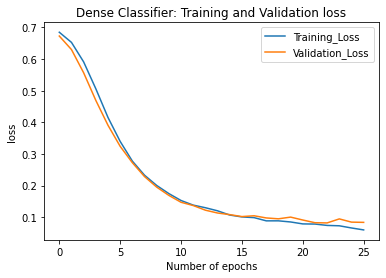

In [80]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

The accuracy plot below shows, the accuracy is increasing over epochs. As expected, the model is performing better in training set than the validation set. If the model performs very well on training data however, its performance is worse in testing data, then it is an indication of overfitting. In our model, we don’t see a significant issue with over-fitting. Moreover, we have accounted for over-fitting problem by using dropout layer and callback earlier.

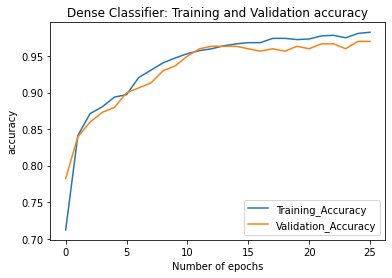

In [81]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

**Long Short Term Memory (LSTM) Model**

Below, we fit the spam detection model using LSTM. Some new hyper-parameters used in LSTM below are n_lstm and return_sequences.

**n_lstm** = 20 is the number of nodes in the hidden layers within the LSTM cell

**return_sequences**=True ensures that the LSTM cell returns all of the outputs from the unrolled LSTM cell through time. If this argument is not used, the LSTM cell will simply provide the output of the LSTM cell from the previous step.
Below are hyper-parameters used for LSTM model.

In [82]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm =0.2

In [83]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

Compiling the LSTM model

In [84]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Training and evaluation LSTM model
The training and evaluations are same as we did for Dense model above.

The validation loss and accuracy from LSTM are 0.31 and 91%, respectively.

In [85]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 2s - loss: 0.6476 - accuracy: 0.6439 - val_loss: 0.5402 - val_accuracy: 0.6941
Epoch 2/30
38/38 - 2s - loss: 0.3750 - accuracy: 0.8610 - val_loss: 0.2697 - val_accuracy: 0.9277
Epoch 3/30
38/38 - 1s - loss: 0.2629 - accuracy: 0.9217 - val_loss: 0.2147 - val_accuracy: 0.9397
Epoch 4/30
38/38 - 2s - loss: 0.2146 - accuracy: 0.9380 - val_loss: 0.1976 - val_accuracy: 0.9420
Epoch 5/30
38/38 - 1s - loss: 0.1853 - accuracy: 0.9447 - val_loss: 0.1776 - val_accuracy: 0.9487
Epoch 6/30
38/38 - 1s - loss: 0.1669 - accuracy: 0.9489 - val_loss: 0.1803 - val_accuracy: 0.9465
Epoch 7/30
38/38 - 1s - loss: 0.1638 - accuracy: 0.9502 - val_loss: 0.1788 - val_accuracy: 0.9484


In [86]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

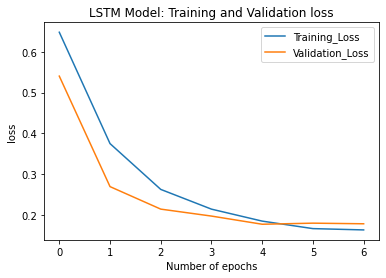

In [87]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

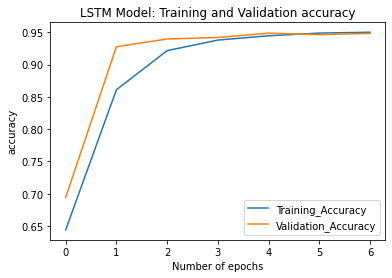

In [88]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

**Bi-directional Long Short Term Memory (BiLSTM) Model**

Unlike in LSTM, the Bi-LSTM learns patterns from both before and after a given token within a document. The Bi-LSTM back-propagates in both backward and forward directions in time. Due to this, the computational time is increased compared to LSTM. However, in most of the cases Bi-LSTM results in better accuracy.

Below, we can see the Bi-directional LSTM architecture, where only difference than LSTM is that we use Bidirectional wrapper to LSTM.

In [91]:

# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [92]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

The validation loss and accuracy from BiLSTM are 0.18 and 95%, respectively.

In [93]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 2s - loss: 0.6820 - accuracy: 0.6094 - val_loss: 0.6491 - val_accuracy: 0.6591
Epoch 2/30
38/38 - 1s - loss: 0.4528 - accuracy: 0.8490 - val_loss: 0.2762 - val_accuracy: 0.9327
Epoch 3/30
38/38 - 1s - loss: 0.2265 - accuracy: 0.9418 - val_loss: 0.2009 - val_accuracy: 0.9399
Epoch 4/30
38/38 - 1s - loss: 0.1742 - accuracy: 0.9515 - val_loss: 0.1683 - val_accuracy: 0.9513
Epoch 5/30
38/38 - 1s - loss: 0.1418 - accuracy: 0.9623 - val_loss: 0.1231 - val_accuracy: 0.9674
Epoch 6/30
38/38 - 1s - loss: 0.1213 - accuracy: 0.9673 - val_loss: 0.1180 - val_accuracy: 0.9678
Epoch 7/30
38/38 - 1s - loss: 0.1014 - accuracy: 0.9749 - val_loss: 0.1482 - val_accuracy: 0.9640
Epoch 8/30
38/38 - 1s - loss: 0.1104 - accuracy: 0.9719 - val_loss: 0.1042 - val_accuracy: 0.9692
Epoch 9/30
38/38 - 1s - loss: 0.0889 - accuracy: 0.9776 - val_loss: 0.1118 - val_accuracy: 0.9705
Epoch 10/30
38/38 - 1s - loss: 0.0825 - accuracy: 0.9813 - val_loss: 0.1087 - val_accuracy: 0.9670


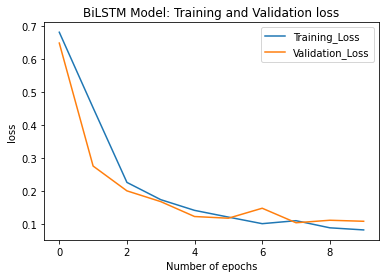

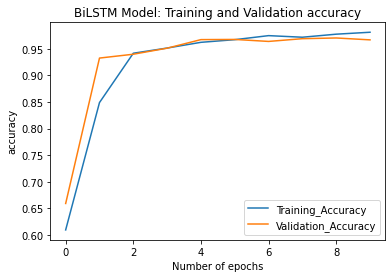

In [94]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

**Comparing three different models and selecting a final one**

All Dense, LSTM and Bi-LSTM models are comparable in terms of loss and accuracy. The validation loss for these three models are 0.13, 0.31 and 0.18, respectively. And, the validation accuracy are 94%, 91% and 95%, respectively.
Among all, both Dense and BiLSTM outperformed the LSTM. Based on loss, accuracy and the plots above, we select Dense architecture as a final model for classifying the text messages for spam or ham. The dense classifier has simple structure and the loss and accuracy over epochs are more stable than in BiLSTM.

In [95]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 1ms/step - loss: 0.0840 - accuracy: 0.9699
Dense architecture loss and accuracy: [0.08397810161113739, 0.9698996543884277] 
10/10 [==============================] - 0s 8ms/step - loss: 0.1788 - accuracy: 0.9484
LSTM architecture loss and accuracy: [0.17876778542995453, 0.9483612179756165] 
10/10 [==============================] - 0s 5ms/step - loss: 0.1087 - accuracy: 0.9670
Bi-LSTM architecture loss and accuracy: [0.10867350548505783, 0.9669564962387085] 


**Predicting spam/ham on new messages**

**Scenario 1**: Using raw text from our data:
Let’s evaluate how our Dense spam detection model predicts/classifies whether its spam or ham given the text from our original data. First and second messages below are ham whereas the third one is a spam message. We’ve used the same tokenizer that we created earlier in the code to convert them into the sequences. This makes sure the new words will have the same token as in the training set. Once tokenized, we use padding as we did earlier and provide the same dimension as in training set.

In [96]:
# display long string 
pd.options.display.max_colwidth=100
messages[:3]

,label,text,length
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,155


In [97]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))

In [98]:
predict_spam(predict_msg)

array([[0.00278762],
       [0.01814729],
       [0.9996588 ]], dtype=float32)

As shown below, the model correctly predicts first two sentences as not spam where as the third one as spam. There is 99% chance that the third sentence is spam.
Image for post
Predicted outcome for raw data
Scenario 2: Using newly created text message and see how the model classifies them.

Below, first sentence is more like a spam whereas the rest of the two sentences are more like ham.

In [99]:
# The third one gives 0.99 indicating very high probabilty of spam
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

array([[0.90730137],
       [0.03955713],
       [0.01308832]], dtype=float32)

This model correctly classifies the first message as spam (94% chance to be spam) were as the rest as ham.


**Summary**

---



We used the text messages from UCI datasets and fit deep learning models such as Dense architecture, LSTM and Bi-LSTM and compared the accuracy and loss on validation set across these models. Finally, we selected the Dense architectural deep learning model to classify text messages as spam or ham and used it to classify new text messages. This code, provides an overview of using different architectural deep learning models to NLP problem using TensorFlow2 Keras.